# 1 Preliminaries
## 1.1 Import
Import required libraries.

In [5]:
import csv
import pandas as pd
import numpy as np
from keras import callbacks, Model, layers, models, optimizers, losses
import chess

## 1.2 Load Data
Load the pgn file and create DataFrame. It should have three columns:
- Color
- Board
- Move

In [6]:
row_val = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
}

def space_to_int(space):
    letter = chess.square_name(space) # returns letter of space (ex. a3)
    return 8-int(letter[1]), row_val[letter[0]] # returns row, column

def split_boards(board):
    """
    Splits board into 14 different boards
    :param board: current board
    :return: length 14 array of boards based on piece location and attack
    0-5 are white pieces (pawn, knight, bishop, rook, queen, king)
    6-11 is black pieces (pawn, knight, bishop, rook, queen, king)
    12 is white legal moves
    13 is black legal moves
    """
    res = np.zeros((14, 8, 8), dtype=np.int8) # creates array of length 14 where each element is a board
    
    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            # gets the location of where the square is and stores it into res
            index = np.unravel_index(square, (8,8)) # see https://stackoverflow.com/questions/48135736/what-is-an-intuitive-explanation-of-np-unravel-index
            res[piece-1][7-index[0]][index[1]] = 1 # 7-index[0] is row, index[1] is column
        for square in board.pieces(piece, chess.BLACK):
            # same idea but black pieces this time
            index = np.unravel_index(square, (8,8))
            res[piece+5][7-index[0]][index[1]] = 1 # +5 because of res indexing
        
    turn = board.turn # store current turn to use later
    
    # get legal moves for white
    board.turn = chess.WHITE
    for move in board.legal_moves:
        r, c = space_to_int(move.to_square)
        res[12][r][c] = 1
        
    # get legal moves for black
    board.turn = chess.BLACK
    for move in board.legal_moves:
        r, c = space_to_int(move.to_square)
        res[13][r][c] = 1
        
    board.turn = turn # restore original turn
    
    return res

X_train = []
y_train = []                
with open('../data/data1.csv', mode ='r') as file:
    csvFile = csv.reader(file)
    next(csvFile) # skip headers
    for line in csvFile:
        board = chess.Board(line[0])
        X_train.append(split_boards(board))
        try:
            eval = int(line[1])
        except ValueError:
            eval = 10000*int(line[1][2]) if line[1][1] == '+' else -10000*int(line[1][2])
        y_train.append(eval/10)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print(X_train.shape)
print(y_train.shape)

(100000, 14, 8, 8)
(100000,)


# 2 Train Model
## 2.1 Create Model

In [7]:
def create_model():
    depth = 2
    
    # input layer
    input = layers.Input(shape=(14,8,8))
    
    # layers
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', data_format='channels_last', activation='relu')(input)
    for i in range(depth):
        previous = x
        x = layers.Conv2D(filters=32, kernel_size=3, padding='same', data_format='channels_last', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=32, kernel_size=3, padding='same', data_format='channels_last', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, previous])
        x = layers.Activation('relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='linear')(x)
    
    model = Model(inputs=input, outputs=x)
    
    optimizer = optimizers.Adam()
    loss = losses.MeanSquaredError()
    metrics = [losses.MeanAbsoluteError()]
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=metrics
    )
    
    print(model.summary())
    
    return model

## 2.2 Fit Model

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 116123.9688 - mean_absolute_error: 52.8421
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 100897.7109 - mean_absolute_error: 43.9970
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 597s 50s/step - loss: 88257.9297 - mean_absolute_error: 46.8915
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 88572.7109 - mean_absolute_error: 46.7938
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 76752.9219 - mean_absolute_error: 47.1029
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 67286.9531 - mean_absolute_error: 43.8210
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 55163.4336 - mean_absolute_error: 41.3528
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 57490.5117 - mean_absolute_error: 42.4536
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 45632.3672 - mean_absolute_error: 39.5897
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 50321.6562 - mean

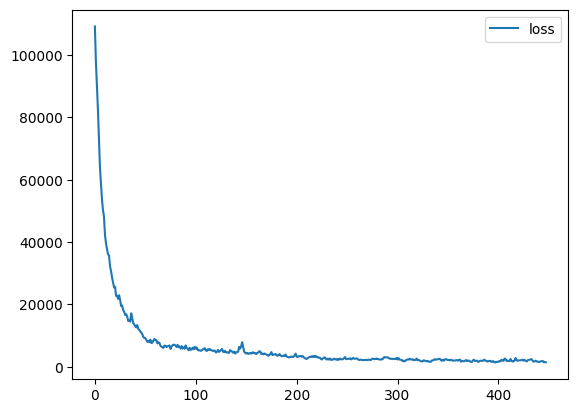

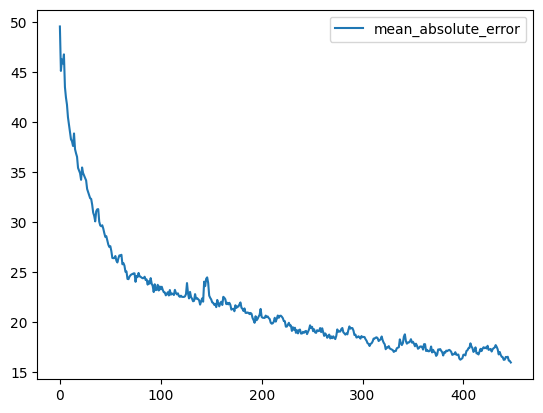

In [9]:
# model = create_model()

model = models.load_model('../models/ai.keras')

early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.0001,  # minimium amount of change to count as an improvement
    patience=50,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    batch_size=8192,
    epochs=1000,
    callbacks=[
        early_stopping,
    ],
    shuffle=True,
    verbose=1,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot()
history_df.loc[:, ['mean_absolute_error']].plot()

model.save('../models/ai.keras')